# Traveling Salesman Deep Dive

In lessons 4 and 5, we cover the traveling salesman problem. We skim over some of the code, because you truly do not need to understand what's happening inside some of the functions in order to be able to use them. But, for those that are curious, let's take a deep dive into the guts of the functions.


## Discrete Optimization Big Ideas
Before we do that, though, let's touch on the big ideas behind all of our discrete optimization problems. There are few commonalities, and if you understand them, you'll see why you don't need to understand what's happening inside the provided functions. You just need to know the purpose of the function.

### Idea One: Every Problem Starts with an Initial State
A "state" is just the current value or set of values for your decision variable(s). We often start with a randomly selected state, but not always. In the knapsack problem, the initial state is an empty backpack. For the traveling salesman problem, the initial state is a randomly selected route that goes through each location. For the gerrymandering problem, the initial state is cities randomly assigned to districts.  

### Idea Two: Every Problem Requires Some Way to Alter the State
The whole point of these optimization problems is that we alter the state to find some minimum or maximum value associated with the state. To get there, we need a way to alter the state. For hand-coded local search, this could be a single line of code that "flips a bit" (like in the knapsack problem) or a function that alters the state in some way (like the subtour_reversal function in the TSP problem). When we do simulated annealing, this will be the "move" function. In genetic algorithms, changing the state is handled by selection, crossover, and mutation. Sometimes we call this "making a move." Sometimes we call this "perturbing the state." 

Whatever we call it, what we're doing is making some **minor** modification to the state, in the hopes that the new state will give us a better result. We want these to be **small moves** so that we find a "nearby" state. We don't want to start with a completely random state every time. We're hoping that we're taking steps "towards" an optimal state, which is called "converging" on the optimal state. If we jump all over the place, it's hard to ever get closer to our goal/converge. 

### Idea Three: Every Problem Requires A Way to Measure the State (the Objective Function)
So we've changed the state. Now what? Every problem requires some way to measure that state. This is the same as having an objective fuction. 

For the knapsack problem, we're summing the value of the items in the knapsack. For the traveling salesman problem, we're figuring out the total length of the route. For the gerrymandering problem, we're determining the number of districts that Republicans win. In our hand-coded problem, this is usually some bit of code the result of which is assigned to the variable new_value. In simulated annealing, this is the function called "energy" and in genetic algorithms this is called evaluating the fitness.

### Idea Four: SOME Problems Include Constraints
For discrete problems, we can use either soft constraints or hard constraints. Detailed information about constraints are covered in the <a href="https://github.com/DeannaDS/shared/blob/master/ds775/Lesson_05_Load_Balancing_With_Constraints.ipynb">Load Balancing with Constraints</a> example.

Okay, with that out of the way, let's dive in to the TSP problem. 

First off, all of the data for this problem is stored in a json file. The json file also handily tells us what the best tour is, so we can start by plotting our best tour. See commented code below.


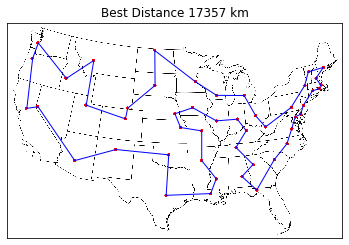

In [4]:
#imports
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

#Pulls in the json file
with open("../data/Caps48.json", "r") as tsp_data:
    tsp = json.load(tsp_data)

#this is our matrix - more on this in a bit    
distance_matrix = tsp["DistanceMatrix"]

#this is where our json file gives us the optimal tour (state) - yay!
optimal_tour = tsp["OptTour"]
#this is where our json file gives us the optimal value (objective function/energy/fitness)
opt_dist = tsp["OptDistance"]/1000 # converted to kilometers

#the coordinates aren't necessary for solving the problem, because we have the distance matrix. 
#But, we use them for plotting the route.
xy = np.array(tsp["Coordinates"])

#You truly don't have to grok this code. It's drawing a line on a base image to show us the route/state.
def plot_tour(best_tour, xy_meters, best_dist, height, width):
    
    meters_to_pxl = 0.0004374627441064968
    intercept_x = 2.464
    intercept_y = 1342.546
    xy_pixels = np.zeros(xy_meters.shape)
    xy_pixels[:,0] = meters_to_pxl * xy_meters[:,0] + intercept_x
    xy_pixels[:,1] = -meters_to_pxl * xy_meters[:,1] + intercept_y

    fig, ax = plt.subplots(1, 1, figsize=(height, width))
    im = plt.imread('images/caps48.png')
    implot = ax.imshow(im)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)

    loop_tour = np.append(best_tour, best_tour[0])
    ax.plot(xy_pixels[loop_tour, 0],
            xy_pixels[loop_tour, 1],
            c='b',
            linewidth=1,
            linestyle='-')
    plt.title('Best Distance {:d} km'.format(int(best_dist)))

plot_tour(optimal_tour, xy, opt_dist, 6, 4)

#### The Distance Matrix
Okay, so what's this distance matrix and how do we use it? You can think of the distance matrix like an excel spreadsheet, with the column names and row names the cities we want to visit on our tour and the values where they intersect the distance between those two cities. 

Let's look at just a snippet of the matrix. We'll fetch the first 5 rows and the first 5 columns of the matrix and print them. We'll also cast to a dataframe and print the first 5 rows and columns that way because it's a little more readable.

Note that there's a diagonal of zeros going through our dataframe. That's because the distance from city 0 to city 0 (the diagonal) is always zero. It's the same place!

In [14]:
#print straight from matrix
for r in range(6):
    print(distance_matrix[r][0:5])

#cast to dataframe for prettier printing    
import pandas as pd
df = pd.DataFrame(distance_matrix)
print(df.iloc[0:5, 0:5])

[0, 2399257, 618109, 3223293, 1856710]
[2399257, 0, 1813867, 1012102, 937629]
[618109, 1813867, 0, 2607102, 1241692]
[3223293, 1012102, 2607102, 0, 1416575]
[1856710, 937629, 1241692, 1416575, 0]
[1585403, 3538445, 1869224, 4087186, 2700860]
         0        1        2        3        4
0        0  2399257   618109  3223293  1856710
1  2399257        0  1813867  1012102   937629
2   618109  1813867        0  2607102  1241692
3  3223293  1012102  2607102        0  1416575
4  1856710   937629  1241692  1416575        0


If I want to find the distance between any two cities, I can use indexing on the matrix to get it. Looking at our output above, we can see that the distance from city 2 to city 4 is 1241692 meters. Let's fetch that from the matrix:

In [17]:
#fetching the distance between city 2 and city 4
distance_matrix[2][4]

1241692

The distance between city 4 and city 2 will be the same.

In [18]:
#fetching the distance between city 4 and city 2
distance_matrix[4][2]

1241692

#### Idea 1: The Initial State
So we have a distance matrix which is our source data, but we don't yet have a starting state. We need some way to generate that. We know that we have 48 cities to traverse. We could traverse them in numerical order as our starting state. That would be a valid choice. But, in our code, we chose instead to start from a randomly ordered permutation. We're using numpy's random permutation function to put the numbers 0-47 into a randomly-ordered numpy array.

In [21]:
#total number of cities
num_cities = 48
#generate a random order of the numbers 0-47
current_tour = np.random.permutation(np.arange(num_cities))
#look at the current tour's order
print(current_tour)

[12 28 27 45 34 13  8 32  3 21 25 30 42 23 38 19  9  4 14 39  0 44 29 18
 36 26 24 33  6 17 47 10  2 43 46 41 37 20  1 22 11  5 31 40 15 16  7 35]


#### Idea Two: Changing The State
Now we need some way to alter this state. We have a function for this called sub_tour_reversal. All this function does is take 2 of the numbers in our state (the numpy array) and swap their places.

In [22]:
def sub_tour_reversal(tour):
    # This bit gets the total length of our tour
    num_cities = len(tour)
    #this bit picks 2 random numbers (cities) from the list of numbers 0-num_cities
    i, j = np.sort(np.random.choice(num_cities, 2, replace=False))
    #return the swapped tour
    return np.concatenate((tour[0:i], tour[j:-num_cities + i - 1:-1],
                              tour[j + 1:num_cities]))

sub_tour_reversal(current_tour)

array([12, 28, 27, 41, 46, 43,  2, 10, 47, 17,  6, 33, 24, 26, 36, 18, 29,
       44,  0, 39, 14,  4,  9, 19, 38, 23, 42, 30, 25, 21,  3, 32,  8, 13,
       34, 45, 37, 20,  1, 22, 11,  5, 31, 40, 15, 16,  7, 35])

There's one piece of this code that's a bit thick, so let's break it down with a smaller example. Let's get a random set of 5 cities:

In [25]:
np.random.seed(1)
small_tour =  np.random.permutation(np.arange(5))
print(small_tour)

[2 1 4 0 3]


Let's manually choose to swap the 1 and the 0. We'll set i to 1 (the 1 is in the second place in the array, starting from zero) and j to 3 (the zero is in the fourth place in the array, starting from zero), and then we'll look at each bit of the return function.

In [72]:
#set i and j
i = 1
j = 3

# see what's in the tour[0:i] bit - this is the part of the array up to i
print(small_tour[0:1])

# see what's in the tour[j:-num_cities + i - 1:-1] (we've hardcoded 5 as the number of cities here)
print(small_tour[j:-5 + i - 1:-1])

#see what's in the tour[j + 1:num_cities] - ths is the bit that's after the part we're swapping
print(small_tour[j + 1:5])

#if we concatenate all that together....
print(np.concatenate((small_tour[0:i], small_tour[j:-5 + i - 1:-1],
                              small_tour[j + 1:5])))


[2]
[0 4 1]
[3]
[2 0 4 1 3]


Note that this code works because we are sorting the i and j numbers. If i is larger than j, this wouldn't work.

#### Idea Three: Measuring the State (the Objective Function)
For this problem, we want to find the route with the shortest distance to travel. So, we need some way to measure the distance on this route. Enter our tour_distance function.

In [73]:
#this is our objective function. It measures the current state (tour) that's passed in.
#it needs the distance matrix to do its work.
def tour_distance(tour, dist_mat):
    distance = dist_mat[tour[-1]][tour[0]]
    for gene1, gene2 in zip(tour[0:-1], tour[1:]):
        distance += dist_mat[gene1][gene2]
    return distance/1000 # convert to kilometers

#get the distance for our starting tour
tour_distance(current_tour, distance_matrix)

80447.668

Once again this code is pretty dense. Let's break it out bit-by-bit.

In [80]:
#let's set some variables so we can run code without calling the function
dist_mat = distance_matrix
#let's use our small tour for demo purposes - remember - just five cities
tour = small_tour

#what's the initial distance variable?
#remember, to get the distance between any two cities, we use indexing. 
#tour[0] is the first city in our tour
print('First city:', tour[0])
#tour[-1] is the last city in our tour
print('Last city:',tour[-1])

#so this bit, is functionally the same as doing dist_mat[3][2] - uncomment the next line to prove it to yourself
#print(dist_mat[3][2])

#this is getting the distance from the last city to our first city
distance = dist_mat[tour[-1]][tour[0]]
print('Distance from last city to first city:', distance)

First city: 2
Last city: 3
Distance from last city to first city: 2607102


Now we have the distance from the last city to first city, but we need to get the distance between each of the other cities. The next bit does just that. First let's see what we get with this zip bit.

In [82]:
#We have to wrap the zip with a list to be able to print it.
list(zip(tour[0:-1], tour[1:]))

[(2, 1), (1, 4), (4, 0), (0, 3)]

This gives us a list of tuples for each city-to-city "hop." Remember that if you have a list of tuples (or a zip object of tuples) you can iterate over it and assign each of the numbers within each tuple to a variable. The function uses gene1 and gene2 as the variable names because it was originally written for a genetic algorithm. But, we could change that to start and end if we wanted to.

In [83]:
for start, end in zip(tour[0:-1], tour[1:]):
    print('Start city:', start, 'end city:', end)
    distance += dist_mat[start][end]
    print('New Running Total for Distance:', distance)

Start city: 2 end city: 1
New Running Total for Distance: 4420969
Start city: 1 end city: 4
New Running Total for Distance: 5358598
Start city: 4 end city: 0
New Running Total for Distance: 7215308
Start city: 0 end city: 3
New Running Total for Distance: 10438601


### Putting It Together
This problem does not have any constaints. All of the routes we might find are feasible routes. So now we just need to try a bunch of routes and see if we can find the best one. 

The minimum distance found is 18430 after 4698 iterations


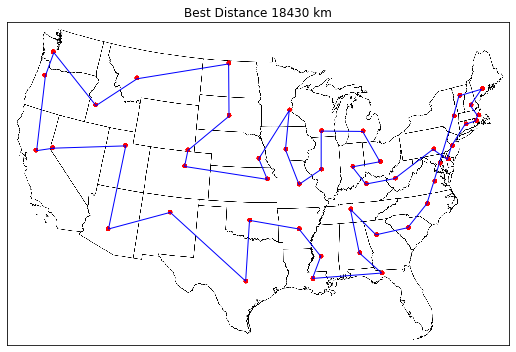

In [84]:
# You could call this function anything you want. The idea is that it's going to try a bunch of moves and track the best state 
def random_reversals(dist_mat, max_no_improve):
    #get the total number of cities - this will be the length of our state variable 
    num_cities = len(dist_mat)
    
    # starts from a random tour - this is the initial state (IDEA #1)
    current_tour = np.random.permutation(np.arange(num_cities))
    
    #this is geting our initial measurement of our objective function (IDEA #3)
    current_dist = tour_distance(current_tour, dist_mat)
    best_tour = current_tour
    best_dist = current_dist

    # stop search if no better tour is found within max_no_improve iterations, can increase to eliminate crossovers
    num_moves_no_improve = 0
    iterations = 0
    while (num_moves_no_improve < max_no_improve):
        num_moves_no_improve += 1
        iterations += 1  # just for tracking
        #this is how we're altering our state (IDEA #2)
        new_tour = sub_tour_reversal(current_tour)
        #here we're measuring our objective function again (IDEA #3)
        new_dist = tour_distance(new_tour, dist_mat)
        #if the current state improves our objective function....
        if new_dist < current_dist:
            num_moves_no_improve = 0
            current_tour = new_tour
            current_dist = new_dist
            if current_dist < best_dist:  # not really needed since current_tour will be best
                best_tour = current_tour  # but we'll use this in the next lesson
                best_dist = current_dist
    return best_tour, best_dist, iterations

#Remember that if your function returns multiple variables like ours does, we have to give it multiple variables to "fill up"
best_tour, best_dist, iterations = random_reversals(distance_matrix, 1000)
plot_tour(best_tour, xy, best_dist, 9, 6)
print('The minimum distance found is {:d} after {:d} iterations'.format(
    int(best_dist), iterations))